## Data prep

* original_embeddings: 1854 concepts * 49 features (euclidean)
* memorability scores
* category mappings: 1324 concepts in 27 higher-level categories
* feature names
* typicality scores: average similarity of 1619 concepts within category


In [147]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.linalg import orthogonal_procrustes
import statsmodels.api as sm
import scipy.stats as stats
from hyperbolicMDS.mds import HyperMDS, cart_to_polar
from matplotlib import colors
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import re, seaborn as sns

data_dir = '../data'
output_dir = '../albatross_49_4D/outputs'

In [148]:
# load original 1854*49 embeddings
original_embeddings = np.loadtxt(os.path.join(data_dir, 'spose_embedding_49d_sorted.txt'))
original_embeddings.shape

(1854, 49)

In [149]:
# load categories and memorability score of each concept
cat_mapping = pd.read_csv(os.path.join(data_dir, 'THINGS_Table.csv'))
cat_concept_mem = cat_mapping[['cr', 'smallcat', 'bigcat']].groupby('smallcat').mean()
cat_concept_mem['bigcat'] = cat_concept_mem['bigcat'].astype(int).replace(0, 99)
cat_concept_mem

,cr,bigcat
smallcat,,
1,0.779739,1
2,0.798485,13
3,0.752845,18
4,0.761851,99
5,0.794466,9
...,...,...
1850,0.722655,99
1851,0.843158,10
1852,0.800163,1


In [150]:
### load category names and merge with concepts
cat = loadmat(os.path.join(data_dir,'categories.mat'))
cat_names = [item[0] for item in cat['categories'][0]]
cat_names.append('na')
cat_names = pd.DataFrame(cat_names, columns=['cat_name']).reset_index()
cat_names['index'] = cat_names['index']+1
cat_names.iloc[27] = [99, np.nan]
cat_concept_mem = cat_concept_mem.merge(cat_names, how='left', left_on='bigcat', right_on='index').drop(columns=['index'])
cat_concept_mem


,cr,bigcat,cat_name
0,0.779739,1,animal
1,0.798485,13,home decor
2,0.752845,18,musical instrument
3,0.761851,99,NaN
4,0.794466,9,electronic device
...,...,...,...
1849,0.722655,99,NaN
1850,0.843158,10,food
1851,0.800163,1,animal
1852,0.797468,99,NaN


In [151]:
### load feature names
feat_short = loadmat(os.path.join(data_dir, 'labels_short.mat'))
feat_short_names = [item[0] for item in feat_short['labels_short'][0]]
features = loadmat(os.path.join(data_dir, 'labels.mat'))
feat_name = [item[0][0] for item in features['labels']]
feat_name

['made of metal / artificial / hard',
 'food-related / eating-related / kitchen-related',
 'animal-related / organic',
 'clothing-related / fabric / covering',
 'furniture-related / household-related / artifact',
 'plant-related / green',
 'outdoors-related',
 'transportation / motorized / dynamic',
 'wood-related / brownish',
 'body part-related',
 'colorful',
 'valuable / special occasion-related',
 'electronic / technology',
 'sport-related / recreational activity-related',
 'disc-shaped / round',
 'tool-related',
 'many small things / course pattern',
 'paper-related / thin / flat / text-related',
 'fluid-related / drink-related',
 'long / thin',
 'water-related / blue',
 'powdery / fine-scale pattern',
 'red',
 'feminine (stereotypically) / decorative',
 'bathroom-related / sanitary',
 'black / noble',
 'weapon / danger-related / violence',
 'musical instrument-related / noise-related',
 'sky-related / flying-related / floating-related',
 'spherical / ellipsoid / rounded / volumin

In [152]:
### load typicality score and merge with concepts
cat_typicality = loadmat(os.path.join(data_dir, 'typicality_data27.mat'))
concept_idx = []
concept_typ = []
concept_cat = []
for cat_idx in range(27):
    concept_idx.extend(pd.DataFrame(cat_typicality['category27_ind'][0][cat_idx])[0].to_list())
    concept_typ.extend(pd.DataFrame(cat_typicality['category27_typicality_rating_normed'][cat_idx][0])[0].to_list())
    concept_cat.extend([cat_idx+1 for i in range(len(cat_typicality['category27_ind'][0][cat_idx]))])
concept_typicality_rated = pd.DataFrame({'cat': concept_cat, 'concept': concept_idx, 'typicality': concept_typ})
concept_typicality_rated['concept'] = concept_typicality_rated['concept']-1
concept_typicality_rated

,cat,concept,typicality
0,1,0,4.874352
1,1,12,6.374555
2,1,15,5.342846
3,1,24,4.655669
4,1,25,5.288886
...,...,...,...
1614,27,1602,7.456293
1615,27,1620,5.922099
1616,27,1684,5.219242
1617,27,1712,3.238293


## 49-dim Feature Space

1. Get 49-dim feature embeddings from albatross results (.npy)
2. Get loadings of 1854 concepts in 49-dim hyperbolic feature space
3. Euclidean vs. mobius vector addition: test out different values of S
4. Get average 49-dim feature space embeddings and 1854 concept loadings through procrustes
5. Analysis: predicting memorability (euclidean vs. mobius)
    * Cartesian coordinates (x, y, z: which axis explains variances in memorability the best)
    * Polar coordinates (r, theta, rho: which angle explains the best)
    * Radius (concepts closer to the core vs. on surface are more memorable?)
    * K-Means clusters:
      - Cartesian coordinates
      - Polar coordinates
6. Analysis: with typicality (euclidean vs. mobius)
    * Calculate typicality: average similarity of each concept pair within category 
    * Predicting typicality
      - Cartesian coordinates
      - Polar coordinates 
      - Radius
    * Predicting memorability
      - Typicality (more prototypical --> more memorable?)
      - Typicality + coordinates/radius to predict memorability
        



In [153]:
### stack albatross outputs
output_dir = '../albatross_49_4D/outputs'
# embeddings = []
# for i in range(10):
#     tmp = np.load(os.path.join(output_dir, f'membatross_embeddings_49_4D_{i}.npy'))
#     embeddings.append(tmp)
# embeddings = np.dstack(embeddings)
# np.save(os.path.join(output_dir, 'membatross_embeddings_49_4D.npy'), embeddings)

In [154]:
# 49-dim feature space embeddings
feature_embeddings = np.load(os.path.join(output_dir, 'membatross_embeddings_49_4D.npy'))
feature_embeddings.shape

(49, 4, 500)

1. `feature_embeddings`: output of ALBATROSS, embbeddings of 49 features that represent where 49 features locate in the 3D hyperbolic space. 
2. By multiplying `original_embeddings` (representations of 1854 concepts in 49-dim euclidean feature space) with `feature_embeddings`, we got `concept_in_feat_coord` that contains the loadings of 1854 concepts in hyperbolic space.
3. Instead of euclidean matrix multiplication (sum of loading * each feature vector), we used einstein scalar multiplication and mobius gyrovetor addition to transform 1854 concepts loadings from 49 feature dimensional space to 3d hyperbolic space. By doing this, loadings on each feature vector were multiplied and added in hyperbolic way, where the parameter S controlled the maximum length of vector (max radius of hyperbolic space).

In [155]:
### normalize embeddings and transform concept embeddings to loadings in hyperbolic feature space
concept_in_feat_coord = []
normalized_embeddings = (original_embeddings.T/np.sqrt((original_embeddings**2).sum(axis=1))).T
for layer in range(feature_embeddings.shape[-1]):
    concept_in_feat_coord.append(normalized_embeddings@feature_embeddings[:,:,layer])
np.array(concept_in_feat_coord).shape

(500, 1854, 4)

Orthogonal procrustes looped through each layer and rotated them so that all layers closely mapped. 

In [156]:
### procrustes of concept loadings in hyperbolic feature space
concept_in_feat_reference = concept_in_feat_coord[0]
concept_in_feat_output = [concept_in_feat_reference]
for i in range(1, len(concept_in_feat_coord)):
    R, scale = orthogonal_procrustes(concept_in_feat_coord[i], concept_in_feat_reference)
    concept_in_feat_output.append(concept_in_feat_coord[i]@R)
concept_in_feat_reference

array([[-3.36494137e+00, -2.96119156e+01, -2.53048416e+01,
        -2.24652066e-01],
       [ 1.21472041e+01,  2.72036658e+00, -6.60501340e+01,
         2.43689549e+01],
       [ 2.88363060e+01, -1.34555007e+00, -7.78649629e+01,
        -2.39905446e+00],
       ...,
       [-5.26973312e-01, -1.74707462e+01, -4.35649441e+01,
         1.45294369e-01],
       [ 1.60726406e+00, -6.70478246e+00, -3.86617424e+01,
         1.00608487e+01],
       [-2.28864506e+01, -2.61057585e+01, -4.45610130e+01,
         9.60294025e-04]])

In [157]:
### procrustes of feature embeddings
feature_embed_reference = feature_embeddings[:,:,0]
feature_embed_output = [feature_embed_reference]
for i in range(1, feature_embeddings.shape[-1]):
    R, scale = orthogonal_procrustes(feature_embeddings[:,:,i], feature_embed_reference)
    feature_embed_output.append(feature_embeddings[:,:,i]@R)

In [158]:
### average across 500 layers
mean_concept_in_feat = np.array(concept_in_feat_output).mean(axis=0)
mean_feature_embed = np.array(feature_embed_output).mean(0)

In [159]:
### merge concept loadings with category and memorability
mean_concept_in_feat_cat = pd.DataFrame(mean_concept_in_feat).reset_index().merge(cat_concept_mem, how='left', left_on='index', right_index=True)
mean_concept_in_feat_cat_na = mean_concept_in_feat_cat.dropna()
mean_concept_in_feat_cat_na

,index,0,1,2,3,cr,bigcat,cat_name
0,0,1.852174,-15.571985,-28.615705,-3.089088,0.779739,1,animal
1,1,9.291067,1.837011,-62.010541,9.666602,0.798485,13,home decor
2,2,4.223185,-1.187159,-61.581791,1.585645,0.752845,18,musical instrument
4,4,1.965069,-8.615136,-50.696231,-2.102075,0.794466,9,electronic device
5,5,-7.086057,-1.709989,-60.070483,1.318659,0.806000,12,furniture
...,...,...,...,...,...,...,...,...
1847,1847,0.999948,-0.682574,-38.302462,15.133705,0.803129,24,toy
1848,1848,-9.857603,-2.456300,-39.178721,6.634859,0.765881,10,food
1850,1850,-6.768393,-3.234056,-36.698193,10.096960,0.843158,10,food
1851,1851,1.285483,-10.261311,-41.514587,-1.875380,0.800163,1,animal


<IPython.core.display.Javascript object>


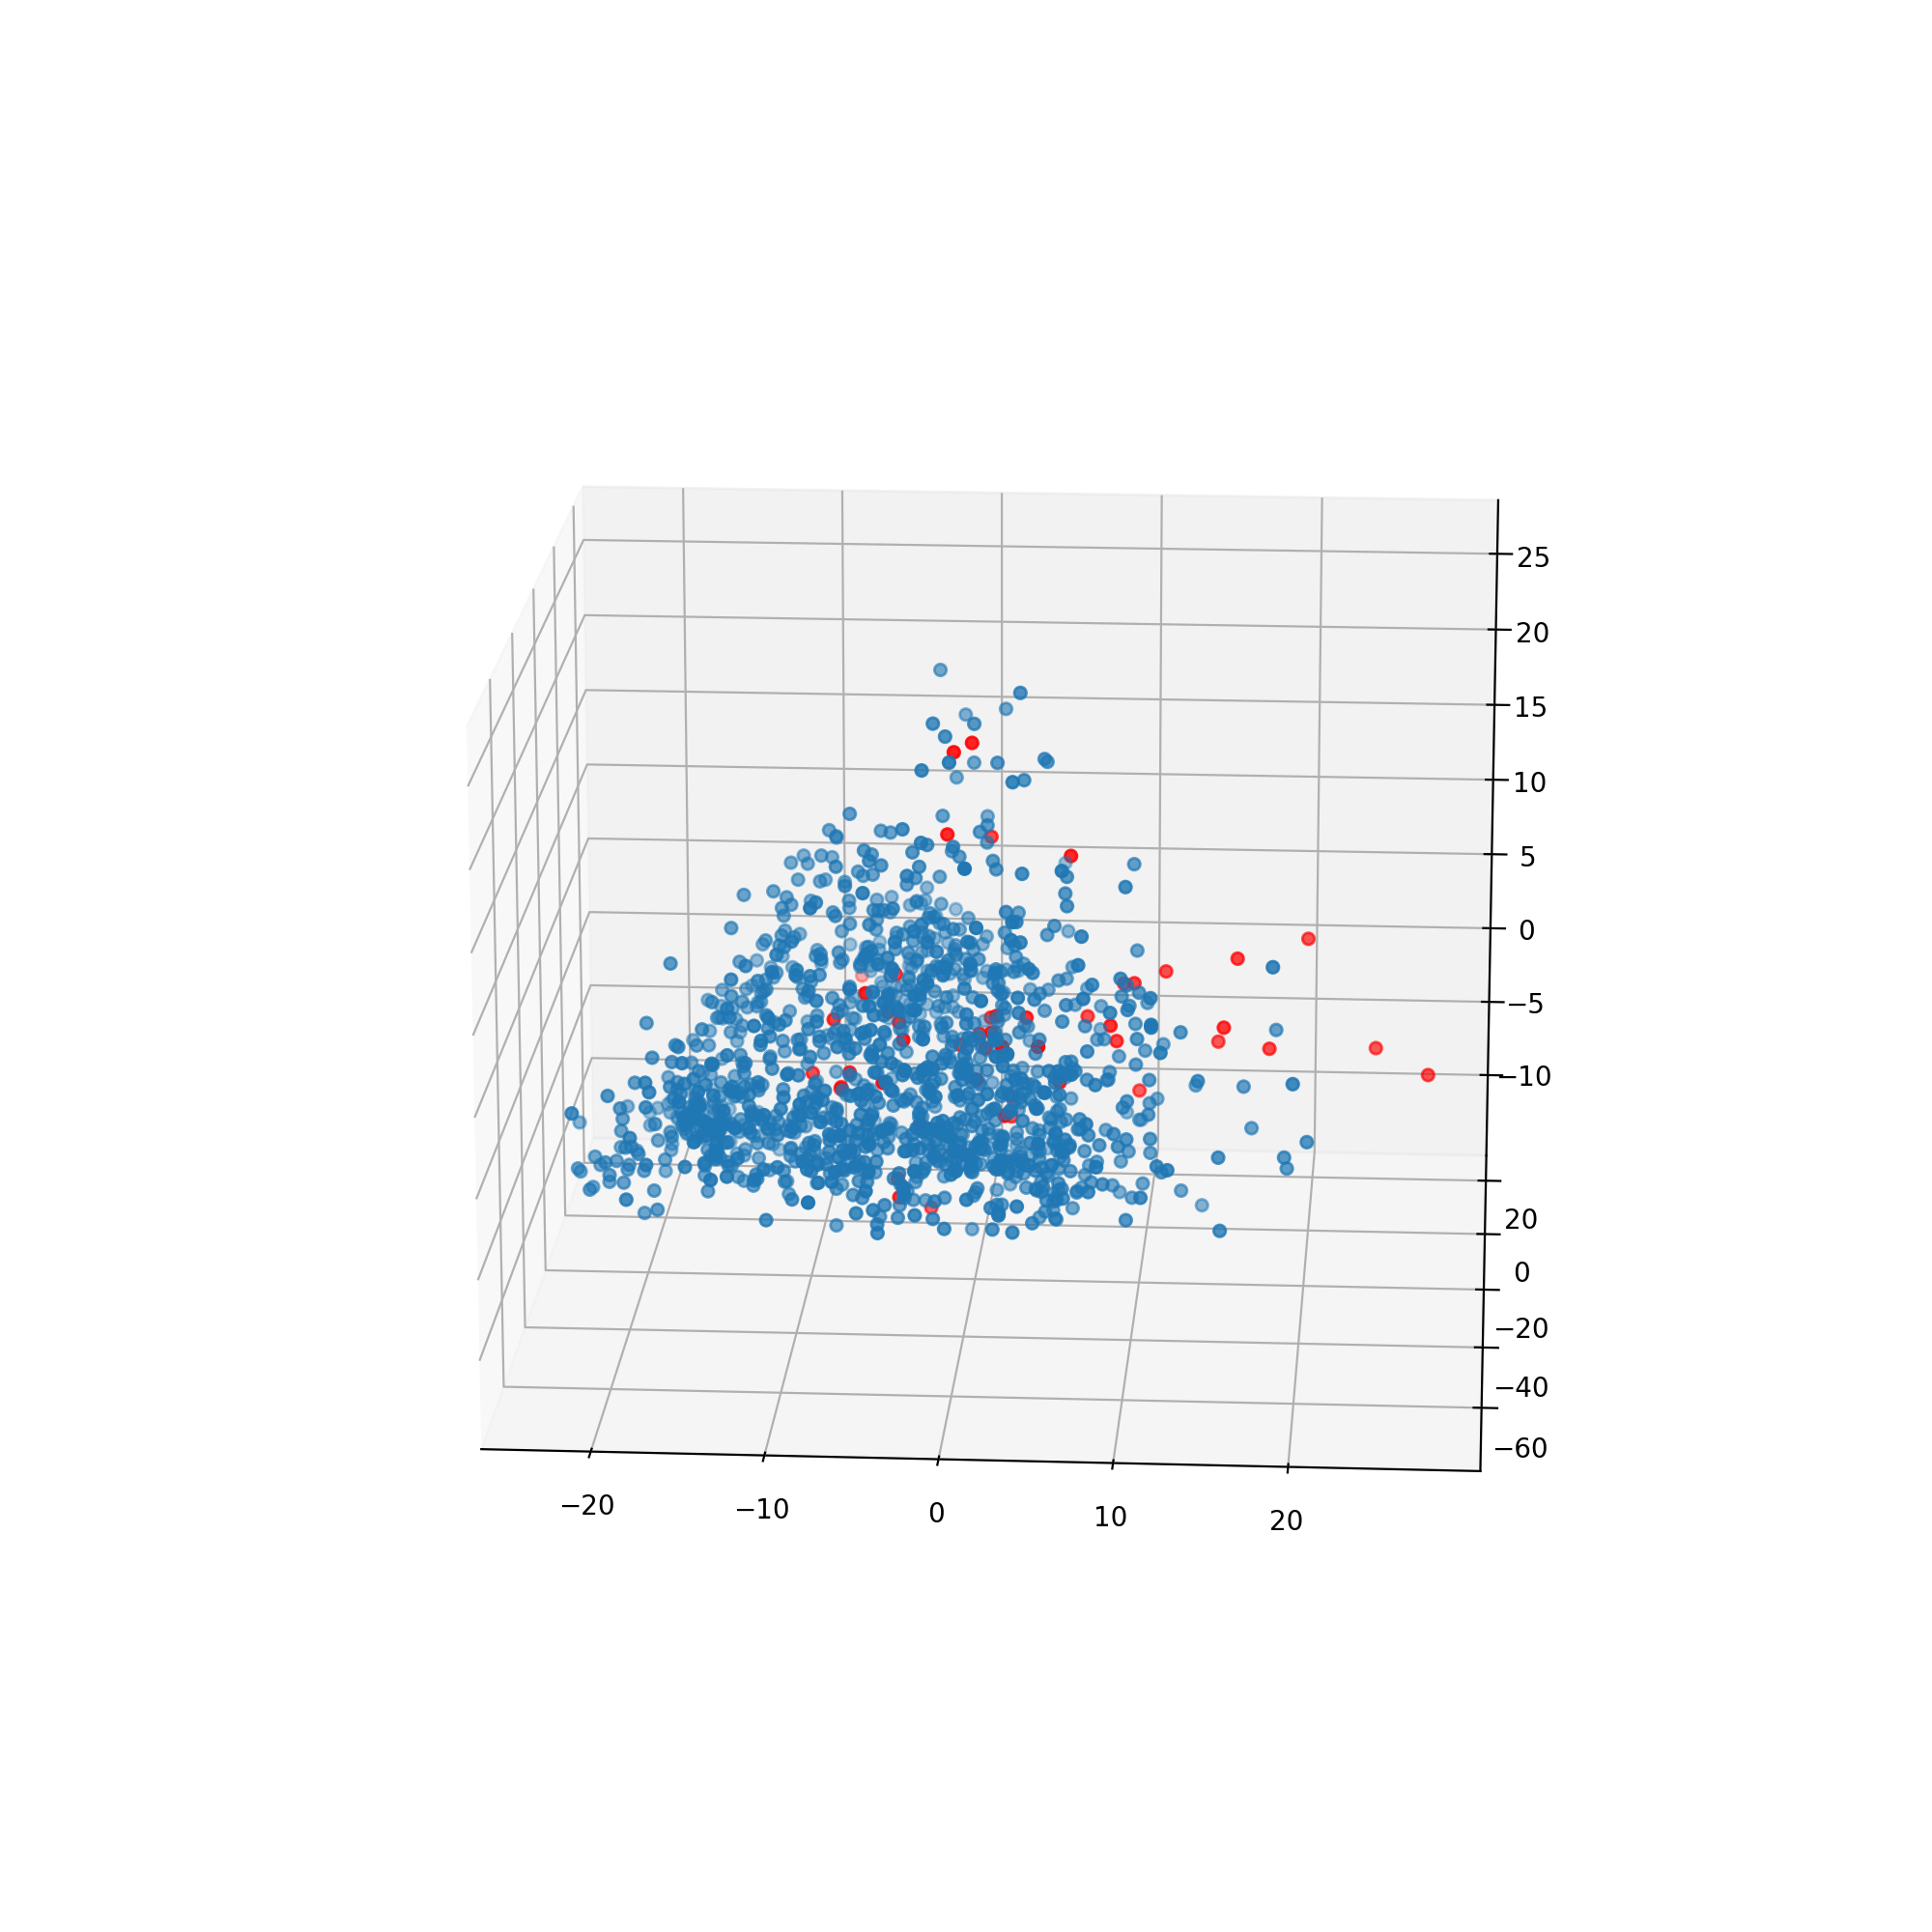

In [160]:
%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

concept_cat = ax.scatter(mean_concept_in_feat_cat_na[1], mean_concept_in_feat_cat_na[2], mean_concept_in_feat_cat_na[3]) 

ax.scatter(mean_feature_embed.T[1], mean_feature_embed.T[2], mean_feature_embed.T[3], color='red')

plt.show()

### Analysis: coordinates vs. memorability

#### Cartesian coordinates
Cartesian coordinates of concepts explained 9.8% of variance in memorability, where x axis is most influential in memorability, while memorability decreased as coordinates going positively along y and z axes. 

In [161]:
### linreg: cartesian coordinates and z-score memorability
# normalized: R^2 = 0.098, adjusted = 0.096
# mobius: R^2 = 0.072, adjusted = 0.06
# mobius (S=48): R^2 = 0.117
import statsmodels.api as sm
import scipy.stats as stats

zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_constant = sm.add_constant(mean_concept_in_feat_cat[[0,1,2,3]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     101.6
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.95e-78
Time:                        13:53:58   Log-Likelihood:                -2446.6
No. Observations:                1854   AIC:                             4903.
Df Residuals:                    1849   BIC:                             4931.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0297      0.002    -14.074      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [162]:
### create a new table to store all regression results
results_index = ['rsquared', 'rsquared_adj', 'coef', 'pvalues', 'AIC', 'BIC', 'F-statistic', 'F-stats-prob', 'Log-Likelihood']
results = pd.DataFrame({'cart_coord_mem':[res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]}, index=results_index)
results

,cart_coord_mem
rsquared,0.180154
rsquared_adj,0.178381
coef,"[-0.029679840434091397, 0.008878808975684906, ..."
pvalues,"[8.195226402455213e-43, 0.002596332887347218, ..."
AIC,4903.147381
BIC,4930.772884
F-statistic,101.575534
F-stats-prob,0.0
Log-Likelihood,-2446.57369


#### Polar coordinates
Predicting memorability using polar coordinates: polar coordinates explained less variance in memorability than cartesian coordinates. Vertical angle of concepts in the hyperbolic space is the most influential variable in predicting memorability, where concepts closer to the core are more memorable, and concepts closer to the ceiling/floor of the space are more forgettable. 

In [163]:
### Polar coordinates of concepts in hyperbolic feature space
# r, theta, rho = cart_to_polar(mean_concept_in_feat_cat[[0,1,2,3]].values).T
# plt.hist2d(theta, rho,
#            bins = 20)

In [164]:
### linreg: polar coordinates vs. memorability
# normalized: R^2 = 0.074, adjusted = 0.072
# mobius: R^2 = 0.019, adjusted = 0.018
# mobius (S=48): R^2 = 0.091

# zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
# mean_concept_constant = sm.add_constant(np.array([r, theta, rho]).T, prepend=False)
# mod = sm.OLS(zscore_mem, mean_concept_constant)

# res = mod.fit()
# print(res.summary())

#### Radius
Predicting memorability using radius: radius of concepts in the hyperbolic space explained even smaller variance in memorability. Concepts that have shorter radius are closer to the core of the space and are more memorable. 

<IPython.core.display.Javascript object>


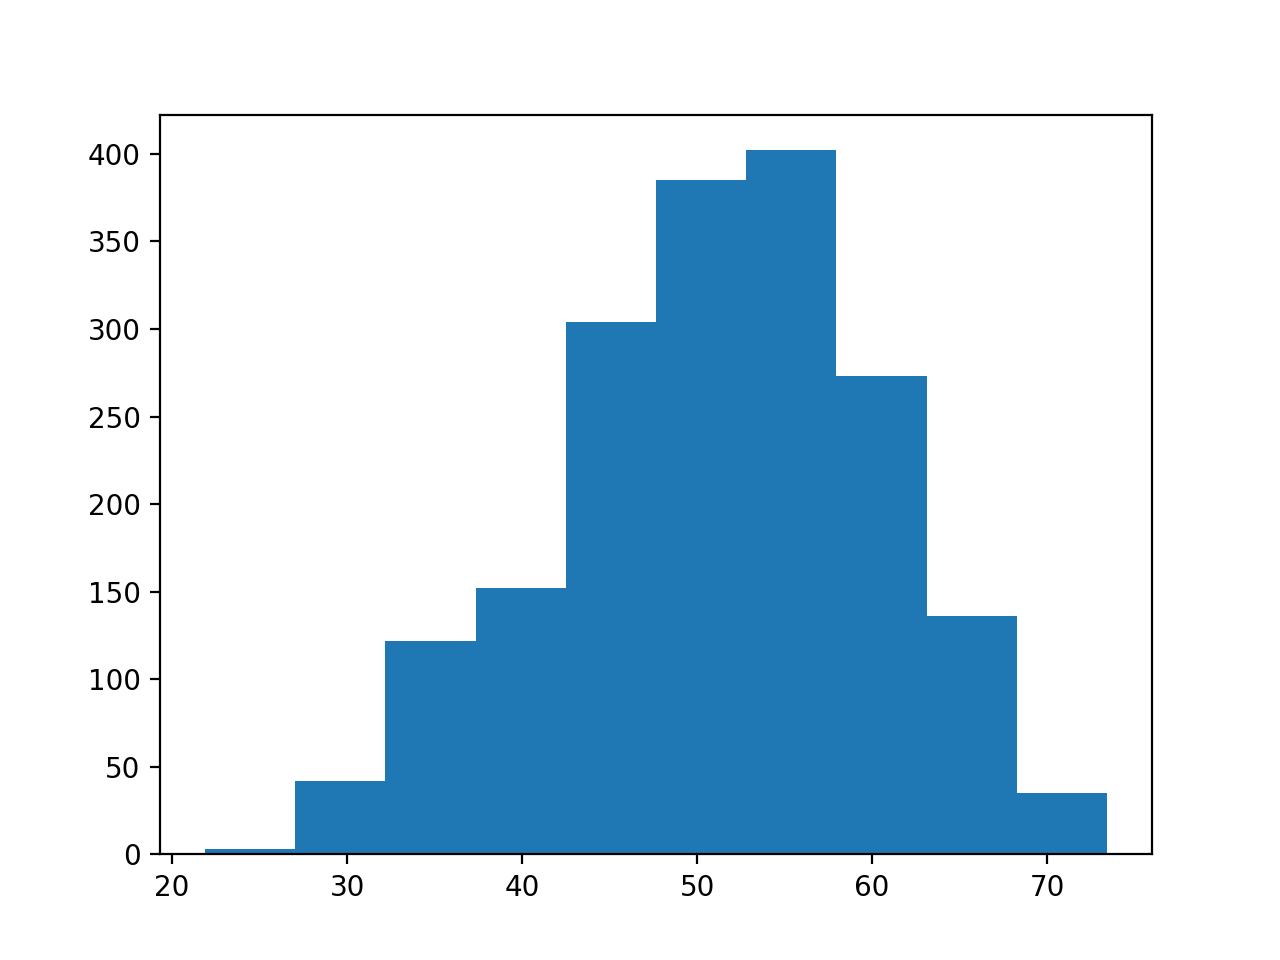

(array([  3.,  42., 122., 152., 304., 385., 402., 273., 136.,  35.]),
 array([21.88945375, 27.04265755, 32.19586134, 37.34906514, 42.50226894,
        47.65547273, 52.80867653, 57.96188033, 63.11508413, 68.26828792,
        73.42149172]),
 <BarContainer object of 10 artists>)

In [165]:
### Radius
%matplotlib notebook
import matplotlib.pyplot as plt
concept_radius_in_feat = np.sqrt((mean_concept_in_feat_cat[[0,1,2,3]]**2).sum(1))

plt.clf()
plt.hist(concept_radius_in_feat)

In [166]:
### Radius vs. memorability
# normalized: R^2 = 0.037, adjusted = 0.037
# mobius: R^2 = 0.014, adjusted = 0.013
zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_radius_const = sm.add_constant(concept_radius_in_feat, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_radius_const)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     37.38
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           1.18e-09
Time:                        13:55:02   Log-Likelihood:                -2612.2
No. Observations:                1854   AIC:                             5228.
Df Residuals:                    1852   BIC:                             5239.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0155      0.003     -6.114      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [167]:
results['radius_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]
results

,cart_coord_mem,radius_mem
rsquared,0.180154,0.019785
rsquared_adj,0.178381,0.019256
coef,"[-0.029679840434091397, 0.008878808975684906, ...","[-0.015496455710579997, 0.7928001892538523]"
pvalues,"[8.195226402455213e-43, 0.002596332887347218, ...","[1.181505087583661e-09, 2.097044229408138e-09]"
AIC,4903.147381,5228.374491
BIC,4930.772884,5239.424693
F-statistic,101.575534,37.381891
F-stats-prob,0.0,0.0
Log-Likelihood,-2446.57369,-2612.187246


#### K-Means
Concepts further away from the core are more memorable in all 4 clusters. Vertical angle has most significantly negative relation with memorability, showing that concepts that are vertically further away from origin are more forgettable. 

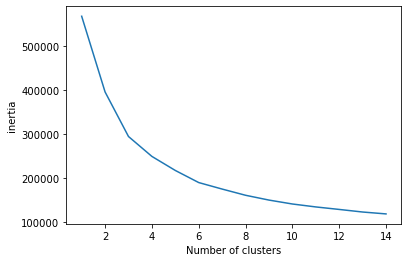

In [168]:
import math

inertia = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(mean_concept_in_feat_cat[[0,1,2,3]])
#     print(kmeans.inertia_)
    inertia.append(kmeans.inertia_)

%matplotlib inline
plt.plot(range(1, 15), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('inertia') 
plt.show()

In [169]:
### K-Means clustering on concepts
kmeans = KMeans(n_clusters=4, random_state=42).fit(mean_concept_in_feat_cat[[0,1,2,3]])
labels = kmeans.labels_
concept_coord_cluster = mean_concept_in_feat_cat
concept_coord_cluster['label'] = labels
kmeans.cluster_centers_


array([[ 4.91337194e+00, -2.47427436e+00, -5.62522970e+01,
         3.04233968e+00],
       [-2.22661093e+01,  5.10074841e+00, -5.03168218e+01,
         1.88767588e-02],
       [-4.87747482e+00, -2.48495672e-01, -4.05151303e+01,
         8.43816659e+00],
       [ 2.88867768e+00, -1.20424069e+01, -4.32952382e+01,
        -2.44600256e-01]])

In [171]:
# ### clusters by memorability and plot concept coordinates in feature space
# %matplotlib notebook


# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')

# ax.scatter(mean_concept_in_feat_cat[0], mean_concept_in_feat_cat[1], mean_concept_in_feat_cat[2], c=labels, alpha=0.5)


In [172]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2,3]], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     7.097
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           1.32e-05
Time:                        13:55:36   Log-Likelihood:                -1009.0
No. Observations:                 721   AIC:                             2028.
Df Residuals:                     716   BIC:                             2051.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0120      0.006     -2.099      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [173]:
### cluster 0: polar coordinates vs. memorability
polar_cluster_0 = cart_to_polar(cluster_0[[0,1,2,3]].values) - cart_to_polar(concept_coord_cluster[[0,1,2,3]].values).mean(0)
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_0, prepend=False)
mod_pol_0 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_0 = mod_pol_0.fit()
print(res_pol_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     5.988
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           9.64e-05
Time:                        13:55:48   Log-Likelihood:                -1011.2
No. Observations:                 721   AIC:                             2032.
Df Residuals:                     716   BIC:                             2055.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0016      0.007     -0.249      0.8

In [174]:
### cluster 0: radius vs. memorability
radius_0 = np.sqrt((cluster_0[[0,1,2,3]]**2).sum(1))
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_0, prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.181
Date:                Wed, 05 Oct 2022   Prob (F-statistic):              0.277
Time:                        13:55:58   Log-Likelihood:                -1022.5
No. Observations:                 721   AIC:                             2049.
Df Residuals:                     719   BIC:                             2058.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0071      0.007     -1.087      0.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [175]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[[0,1,2,3]], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     26.47
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           1.68e-18
Time:                        13:56:08   Log-Likelihood:                -340.53
No. Observations:                 272   AIC:                             691.1
Df Residuals:                     267   BIC:                             709.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0694      0.007     -9.497      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [176]:
### cluster 1: polar coordinates vs. memorability
polar_cluster_1 = cart_to_polar(cluster_1[[0,1,2,3]].values) - cart_to_polar(concept_coord_cluster[[0,1,2,3]].values).mean(0)
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_1, prepend=False)
mod_pol_1 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_1 = mod_pol_1.fit()
print(res_pol_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     25.94
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           3.52e-18
Time:                        13:56:19   Log-Likelihood:                -341.30
No. Observations:                 272   AIC:                             692.6
Df Residuals:                     267   BIC:                             710.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0254      0.009      2.797      0.0

In [177]:
### cluster 1: radius vs. memorability
radius_1 = np.sqrt((cluster_1[[0,1,2,3]]**2).sum(1))
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_1, prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.208
Date:                Wed, 05 Oct 2022   Prob (F-statistic):              0.273
Time:                        13:56:22   Log-Likelihood:                -385.34
No. Observations:                 272   AIC:                             774.7
Df Residuals:                     270   BIC:                             781.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0113      0.010      1.099      0.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [178]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[[0,1,2,3]], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     8.943
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           6.00e-07
Time:                        13:56:31   Log-Likelihood:                -608.36
No. Observations:                 441   AIC:                             1227.
Df Residuals:                     436   BIC:                             1247.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0373      0.012     -3.207      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [179]:
### cluster 2: polar coordinates vs. memorability
polar_cluster_2 = cart_to_polar(cluster_2[[0,1,2,3]].values) - cart_to_polar(concept_coord_cluster[[0,1,2,3]].values).mean(0)
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_2, prepend=False)
mod_pol_2 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_2 = mod_pol_2.fit()
print(res_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     6.324
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           5.93e-05
Time:                        13:56:32   Log-Likelihood:                -613.32
No. Observations:                 441   AIC:                             1237.
Df Residuals:                     436   BIC:                             1257.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0184      0.007     -2.499      0.0

In [180]:
### cluster 2: radius vs. memorability
radius_2 = np.sqrt((cluster_2[[0,1,2,3]]**2).sum(1))
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_2, prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     10.28
Date:                Wed, 05 Oct 2022   Prob (F-statistic):            0.00144
Time:                        13:56:42   Log-Likelihood:                -620.65
No. Observations:                 441   AIC:                             1245.
Df Residuals:                     439   BIC:                             1253.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0211      0.007     -3.207      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [181]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[[0,1,2,3]], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     13.72
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           1.62e-10
Time:                        13:56:53   Log-Likelihood:                -569.87
No. Observations:                 420   AIC:                             1150.
Df Residuals:                     415   BIC:                             1170.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0190      0.009     -2.004      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [182]:
### cluster 3: polar coordinates vs. memorability
polar_cluster_3 = cart_to_polar(cluster_3[[0,1,2,3]].values) - cart_to_polar(concept_coord_cluster[[0,1,2,3]].values).mean(0)
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_3, prepend=False)
mod_pol_3 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_3 = mod_pol_3.fit()
print(res_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     12.94
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           6.17e-10
Time:                        13:56:55   Log-Likelihood:                -571.28
No. Observations:                 420   AIC:                             1153.
Df Residuals:                     415   BIC:                             1173.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0330      0.008     -4.031      0.0

In [183]:
### cluster 3: radius vs. memorability
radius_3 = np.sqrt((cluster_3[[0,1,2,3]]**2).sum(1))
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_3, prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     37.73
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           1.90e-09
Time:                        13:57:06   Log-Likelihood:                -577.81
No. Observations:                 420   AIC:                             1160.
Df Residuals:                     418   BIC:                             1168.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0458      0.007     -6.142      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [184]:
# ### Memorability changes by coordinates in each cluster
# # normalized: highest R^2 (cluster 1) = 0.318
# # mobius: highest R^2 (cluster 3) = 0.123

# %matplotlib notebook

# # plt.clf()
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')

# ax.scatter(cluster_0[0], cluster_0[1], cluster_0[2], label='cluster_0', alpha=0.3)
# # ax.plot(np.linspace(-30,-20,100), np.linspace(10,20,100), -2.5+-.5+np.linspace(-30,-20,100)*.0057+ np.linspace(10,20,100)*.0509+ np.linspace(-7.5, 2.5, 100)*.0108, label='cluster_0', alpha=1)
# # ax.plot(np.linspace(-15,-5,100), np.linspace(5,15,100), -.3135+np.linspace(-15,-5,100)*.1324+ np.linspace(5,15,100)*.1098+ np.linspace(-5, 5, 100)*-.0734, label='cluster_0', alpha=1)
# ax.quiver(-30, 10, -7.5, 10, 10, 10, length = 10, normalize = True, color='blue')


# # c0_grid = np.meshgrid(np.linspace(-20,-30,100), np.linspace(10,20,100))
# # ax.plot_surface(c0_grid[0], c0_grid[1], -.5+X*.0057+ Y*.0509, label='cluster_0', alpha=1)

# ax.scatter(cluster_1[0], cluster_1[1], cluster_1[2], label='cluster_1', alpha=0.3)
# # ax.plot(np.linspace(-20,-10,100), np.linspace(10,20,100), .59+np.linspace(-20,-10,100)*.1288+ np.linspace(10,20,100)*.1266+ np.linspace(-5, 5, 100)*.0101, label='cluster_1', alpha=1)
# # ax.plot(np.linspace(-20,-10,100), np.linspace(-2.5,7.5,100), -1.5349+np.linspace(-20,-10,100)*-.1115+ np.linspace(-2.5,7.5,100)*-.0823+ np.linspace(-5, 5, 100)*.0273, label='cluster_1', alpha=1)
# ax.quiver(-20, 10, -5, 10, 10, 10, length = 10, normalize = True, color='orange')


# # c1_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(10,20,100))
# # ax.plot_surface(c1_grid[0], c1_grid[1], .59+X*.1288+ Y*.1266, label='cluster_1', alpha=1)

# ax.scatter(cluster_2[0], cluster_2[1], cluster_2[2], label='cluster_2', alpha=0.3)
# # ax.plot(np.linspace(-25,-15,100), np.linspace(0,10,100), -.49+np.linspace(-25,-15,100)*-.0665+ np.linspace(0,10,100)*-.1488+ np.linspace(-7.5, 2.5, 100)*-.0007, label='cluster_2', alpha=1)
# # ax.plot(np.linspace(-15,-5,100), np.linspace(10,0,100), 1.6519+np.linspace(-15,-5,100)*.1747+ np.linspace(10,0,100)*-.0601+ np.linspace(0, 10, 100)*.0127, label='cluster_2', alpha=1)
# ax.quiver(-15, 0, 2.5, -10, 10, -10, length = 10, normalize = True, color='green')


# # c2_grid = np.meshgrid(np.linspace(-25,-15,100), np.linspace(0,10,100))
# # ax.plot_surface(c2_grid[0], c2_grid[1], -.49+X*-.0665+ Y*-.1488, label='cluster_2', alpha=1)

# ax.scatter(cluster_3[0], cluster_3[1], cluster_3[2], label='cluster_3', alpha=0.3)
# # ax.plot(np.linspace(-20,-10,100), np.linspace(5,15,100), -10+.47+np.linspace(-20,-10,100)*.1483+ np.linspace(5,15,100)*.1887+ np.linspace(-12.5, -7.5, 100)*.0244, label='cluster_3', alpha=1)
# # ax.plot(np.linspace(-17.5,-7.5,100), np.linspace(10,0,100), 1.0544+np.linspace(-17.5,-7.5,100)*.1962+ np.linspace(10,0,100)*-.1758+ np.linspace(0, -10, 100)*.0596, label='cluster_3', alpha=1)
# ax.quiver(-20, 5, -12.5, 10, 10, 10, length = 10, normalize = True, color='red')


# # c3_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(5,15,100))
# # ax.plot_surface(c3_grid[0], c3_grid[1], .47+X*.1483+ Y*.1887, label='cluster_3', alpha=1)

# ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='purple', alpha=.3)

# plt.legend()


In [185]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_mem'].append(r_squared)
r_squared

0.10098339997592687

In [186]:
r_squared = 1 - (sum((zscore_mem_0 - res_pol_0.fittedvalues)**2) + sum((zscore_mem_1 - res_pol_1.fittedvalues)**2) + sum((zscore_mem_2 - res_pol_2.fittedvalues)**2) + sum((zscore_mem_3 - res_pol_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.09181190358653468

In [187]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_mem'].append(r_squared)
r_squared

0.025489280810405246

### Analysis: coordinates, typicality, memorability


In [188]:
def calculate_typicality(group):
    """
    Calculate typicality of each concept using average similarity within category 
    """
    feat_matrix = []
    for concept in group['index']:
        feat_matrix.append(original_embeddings[concept])
    coef_matrix = np.corrcoef(feat_matrix)
    typicality = (np.sum(coef_matrix, axis=1)-1)/len(coef_matrix)
    group['typicality'] = typicality
    return group

In [189]:
grouped = mean_concept_in_feat_cat_na.groupby('bigcat')
grouped = grouped.apply(calculate_typicality)
grouped

,index,0,1,2,3,cr,bigcat,cat_name,typicality
0,0,1.852174,-15.571985,-28.615705,-3.089088,0.779739,1,animal,0.810913
1,1,9.291067,1.837011,-62.010541,9.666602,0.798485,13,home decor,0.247628
2,2,4.223185,-1.187159,-61.581791,1.585645,0.752845,18,musical instrument,0.624589
4,4,1.965069,-8.615136,-50.696231,-2.102075,0.794466,9,electronic device,0.522380
5,5,-7.086057,-1.709989,-60.070483,1.318659,0.806000,12,furniture,0.509185
...,...,...,...,...,...,...,...,...,...
1847,1847,0.999948,-0.682574,-38.302462,15.133705,0.803129,24,toy,0.246697
1848,1848,-9.857603,-2.456300,-39.178721,6.634859,0.765881,10,food,0.786900
1850,1850,-6.768393,-3.234056,-36.698193,10.096960,0.843158,10,food,0.770485
1851,1851,1.285483,-10.261311,-41.514587,-1.875380,0.800163,1,animal,0.764335


In [190]:
### Cartesian coordinates vs. typicality
# normalized: R^2 = 0.479, adjusted = 0.478
# mobius: R^2 = 0.136, adjusted = 0.134

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(grouped[[0,1,2,3]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     315.9
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          1.13e-190
Time:                        13:57:56   Log-Likelihood:                -1433.8
No. Observations:                1324   AIC:                             2878.
Df Residuals:                    1319   BIC:                             2904.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0144      0.002     -7.296      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [191]:
### Polar coordinates vs. typicality
polar_coord = pd.DataFrame(cart_to_polar(grouped[[0,1,2,3]].values))

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(polar_coord.values, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     239.2
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          1.57e-154
Time:                        13:58:07   Log-Likelihood:                -1517.5
No. Observations:                1324   AIC:                             3045.
Df Residuals:                    1319   BIC:                             3071.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0579      0.002    -24.120      0.0

In [192]:
### Radius vs. typicality
concept_radius_typ = np.sqrt((grouped[[0,1,2,3]]**2).sum(1))
zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_typ, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     637.8
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          3.65e-115
Time:                        13:58:09   Log-Likelihood:                -1618.0
No. Observations:                1324   AIC:                             3240.
Df Residuals:                    1322   BIC:                             3250.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0614      0.002    -25.255      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [193]:
### typicality vs. memorability
# R^2 = 0.032, adjusted = 0.031

zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(grouped['typicality'], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     43.72
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           5.50e-11
Time:                        13:58:13   Log-Likelihood:                -1857.1
No. Observations:                1324   AIC:                             3718.
Df Residuals:                    1322   BIC:                             3729.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
typicality     0.9536      0.144      6.612      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [194]:
### Cartesian coordinates and typicality vs. memorability
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array(grouped[[0,1,2,3,'typicality']]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     59.37
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           7.51e-56
Time:                        13:58:47   Log-Likelihood:                -1744.2
No. Observations:                1324   AIC:                             3500.
Df Residuals:                    1318   BIC:                             3532.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0273      0.003    -10.752      0.0

In [195]:
### Polar coordinates and typicality vs. memorability
# zscore_mem = stats.zscore(grouped['cr'])
# mean_concept_constant = sm.add_constant(np.array([grouped['typicality'], r, theta, rho]).T, prepend=False)
# mod = sm.OLS(zscore_mem, mean_concept_constant)

# res = mod.fit()
# print(res.summary())

In [196]:
### Radius and typicality vs. memorability
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array([grouped['typicality'], concept_radius_typ]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     23.06
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           1.43e-10
Time:                        13:59:05   Log-Likelihood:                -1856.0
No. Observations:                1324   AIC:                             3718.
Df Residuals:                    1321   BIC:                             3733.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7996      0.176      4.556      0.0

#### Cluster level typicality

In [197]:
# ### K-Means clustering on concepts
# kmeans = KMeans(n_clusters=4, random_state=42).fit(grouped[[0,1,2]])
# labels = kmeans.labels_
# concept_coord_cluster = grouped
# concept_coord_cluster['label'] = labels
# kmeans.cluster_centers_


In [198]:
typ_coord_cluster = concept_coord_cluster.merge(grouped[['index','typicality']], how='inner', on='index')
typ_coord_cluster

,index,0,1,2,3,cr,bigcat,cat_name,label,typicality
0,0,1.852174,-15.571985,-28.615705,-3.089088,0.779739,1,animal,3,0.810913
1,1,9.291067,1.837011,-62.010541,9.666602,0.798485,13,home decor,0,0.247628
2,2,4.223185,-1.187159,-61.581791,1.585645,0.752845,18,musical instrument,0,0.624589
3,4,1.965069,-8.615136,-50.696231,-2.102075,0.794466,9,electronic device,3,0.522380
4,5,-7.086057,-1.709989,-60.070483,1.318659,0.806000,12,furniture,0,0.509185
...,...,...,...,...,...,...,...,...,...,...
1319,1847,0.999948,-0.682574,-38.302462,15.133705,0.803129,24,toy,2,0.246697
1320,1848,-9.857603,-2.456300,-39.178721,6.634859,0.765881,10,food,2,0.786900
1321,1850,-6.768393,-3.234056,-36.698193,10.096960,0.843158,10,food,2,0.770485
1322,1851,1.285483,-10.261311,-41.514587,-1.875380,0.800163,1,animal,3,0.764335


In [199]:
### cluster 0: cartesian coordinates and typicality vs. memorability
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2,3, 'typicality']], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_typ_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     2.812
Date:                Wed, 05 Oct 2022   Prob (F-statistic):             0.0164
Time:                        13:59:19   Log-Likelihood:                -584.69
No. Observations:                 417   AIC:                             1181.
Df Residuals:                     411   BIC:                             1206.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0008      0.008     -0.104      0.9

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [200]:
### cluster 0: polar coordinates and typicality vs. memorability
polar_cluster_0 = cluster_0.copy()
polar_cluster_0[[0,1,2,3]] = cart_to_polar(cluster_0[[0,1,2,3]].values) - cart_to_polar(typ_coord_cluster[[0,1,2,3]].values).mean(0)
zscore_mem = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_0[[0,1,2,3,'typicality']], prepend=False)
mod_pol_0 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_0 = mod_pol_0.fit()
print(res_pol_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     3.220
Date:                Wed, 05 Oct 2022   Prob (F-statistic):            0.00729
Time:                        13:59:21   Log-Likelihood:                -583.69
No. Observations:                 417   AIC:                             1179.
Df Residuals:                     411   BIC:                             1204.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0025      0.009      0.281      0.7

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [201]:
### cluster 0: radius and typicality vs. memorability
polar_cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:3]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_typ_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.01499
Date:                Wed, 05 Oct 2022   Prob (F-statistic):              0.985
Time:                        13:59:30   Log-Likelihood:                -591.68
No. Observations:                 417   AIC:                             1189.
Df Residuals:                     414   BIC:                             1201.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0010      0.009     -0.113      0.9

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [202]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[[0,1,2,3,'typicality']], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     12.82
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           8.29e-11
Time:                        13:59:39   Log-Likelihood:                -260.85
No. Observations:                 204   AIC:                             533.7
Df Residuals:                     198   BIC:                             553.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0624      0.010     -6.101      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [203]:
### cluster 1: polar coordinates and typicality vs. memorability
polar_cluster_1 = cluster_1.copy()
polar_cluster_1[[0,1,2,3]] = cart_to_polar(cluster_1[[0,1,2,3]].values) - cart_to_polar(typ_coord_cluster[[0,1,2,3]].values).mean(0)
zscore_mem = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_1[[0,1,2,3,'typicality']], prepend=False)
mod_pol_1 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_1 = mod_pol_1.fit()
print(res_pol_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     12.94
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           6.74e-11
Time:                        13:59:41   Log-Likelihood:                -260.62
No. Observations:                 204   AIC:                             533.2
Df Residuals:                     198   BIC:                             553.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0263      0.011      2.299      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [204]:
### cluster 1: radius and typicality vs. memorability
polar_cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:3]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     11.10
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.67e-05
Time:                        13:59:51   Log-Likelihood:                -278.78
No. Observations:                 204   AIC:                             563.6
Df Residuals:                     201   BIC:                             573.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0180      0.012      1.484      0.1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [205]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[[0,1,2,3,'typicality']], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     6.709
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           5.60e-06
Time:                        14:00:02   Log-Likelihood:                -473.26
No. Observations:                 345   AIC:                             958.5
Df Residuals:                     339   BIC:                             981.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0244      0.015     -1.605      0.1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [206]:
### cluster 2: polar coordinates vs. memorability
polar_cluster_2 = cluster_2.copy()
polar_cluster_2[[0,1,2,3]] = cart_to_polar(cluster_2[[0,1,2,3]].values) - cart_to_polar(typ_coord_cluster[[0,1,2,3]].values).mean(0)
zscore_mem = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_2[[0,1,2,3,'typicality']], prepend=False)
mod_pol_2 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_2 = mod_pol_2.fit()
print(res_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     6.759
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           5.05e-06
Time:                        14:00:03   Log-Likelihood:                -473.14
No. Observations:                 345   AIC:                             958.3
Df Residuals:                     339   BIC:                             981.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0002      0.010      0.022      0.9

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [207]:
### cluster 2: radius and typicality vs. memorability
polar_cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:3]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     8.650
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           0.000216
Time:                        14:00:13   Log-Likelihood:                -481.02
No. Observations:                 345   AIC:                             968.0
Df Residuals:                     342   BIC:                             979.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0008      0.010      0.081      0.9

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [208]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[[0,1,2,3,'typicality']], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     9.319
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.38e-08
Time:                        14:00:21   Log-Likelihood:                -485.73
No. Observations:                 358   AIC:                             983.5
Df Residuals:                     352   BIC:                             1007.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0185      0.011     -1.760      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [209]:
### cluster 3: polar coordinates vs. memorability
polar_cluster_3 = cluster_3.copy()
polar_cluster_3[[0,1,2,3]] = cart_to_polar(cluster_3[[0,1,2,3]].values) - cart_to_polar(typ_coord_cluster[[0,1,2,3]].values).mean(0)
zscore_mem = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_3[[0,1,2,3,'typicality']], prepend=False)
mod_pol_3 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_3 = mod_pol_3.fit()
print(res_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     9.013
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           4.49e-08
Time:                        14:00:23   Log-Likelihood:                -486.42
No. Observations:                 358   AIC:                             984.8
Df Residuals:                     352   BIC:                             1008.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0257      0.009     -2.912      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [210]:
### cluster 3: radius and typicality vs. memorability
polar_cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:3]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     18.58
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.13e-08
Time:                        14:00:34   Log-Likelihood:                -490.16
No. Observations:                 358   AIC:                             986.3
Df Residuals:                     355   BIC:                             998.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0318      0.009     -3.736      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [211]:
# ### Memorability changes by coordinates in each cluster
# # normalized: highest R^2 (cluster 1) = 0.318
# # mobius: highest R^2 (cluster 3) = 0.123

# %matplotlib notebook

# # plt.clf()
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')

# ax.scatter(cluster_0[0], cluster_0[1], cluster_0[2], label='cluster_0', alpha=0.3)
# # ax.plot(np.linspace(-30,-20,100), np.linspace(10,20,100), -2.5+-.5+np.linspace(-30,-20,100)*.0057+ np.linspace(10,20,100)*.0509+ np.linspace(-7.5, 2.5, 100)*.0108, label='cluster_0', alpha=1)
# # ax.plot(np.linspace(-15,-5,100), np.linspace(5,15,100), -.3135+np.linspace(-15,-5,100)*.1324+ np.linspace(5,15,100)*.1098+ np.linspace(-5, 5, 100)*-.0734, label='cluster_0', alpha=1)
# # ax.quiver(-30, 10, -7.5, 10, 10, 10, length = 10, normalize = True, color='blue')


# # c0_grid = np.meshgrid(np.linspace(-20,-30,100), np.linspace(10,20,100))
# # ax.plot_surface(c0_grid[0], c0_grid[1], -.5+X*.0057+ Y*.0509, label='cluster_0', alpha=1)

# ax.scatter(cluster_1[0], cluster_1[1], cluster_1[2], label='cluster_1', alpha=0.3)
# # ax.plot(np.linspace(-20,-10,100), np.linspace(10,20,100), .59+np.linspace(-20,-10,100)*.1288+ np.linspace(10,20,100)*.1266+ np.linspace(-5, 5, 100)*.0101, label='cluster_1', alpha=1)
# # ax.plot(np.linspace(-20,-10,100), np.linspace(-2.5,7.5,100), -1.5349+np.linspace(-20,-10,100)*-.1115+ np.linspace(-2.5,7.5,100)*-.0823+ np.linspace(-5, 5, 100)*.0273, label='cluster_1', alpha=1)
# # ax.quiver(-20, 10, -5, 10, 10, 10, length = 10, normalize = True, color='orange')


# # c1_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(10,20,100))
# # ax.plot_surface(c1_grid[0], c1_grid[1], .59+X*.1288+ Y*.1266, label='cluster_1', alpha=1)

# ax.scatter(cluster_2[0], cluster_2[1], cluster_2[2], label='cluster_2', alpha=0.3)
# # ax.plot(np.linspace(-25,-15,100), np.linspace(0,10,100), -.49+np.linspace(-25,-15,100)*-.0665+ np.linspace(0,10,100)*-.1488+ np.linspace(-7.5, 2.5, 100)*-.0007, label='cluster_2', alpha=1)
# # ax.plot(np.linspace(-15,-5,100), np.linspace(10,0,100), 1.6519+np.linspace(-15,-5,100)*.1747+ np.linspace(10,0,100)*-.0601+ np.linspace(0, 10, 100)*.0127, label='cluster_2', alpha=1)
# # ax.quiver(-15, 0, 2.5, -10, 10, -10, length = 10, normalize = True, color='green')


# # c2_grid = np.meshgrid(np.linspace(-25,-15,100), np.linspace(0,10,100))
# # ax.plot_surface(c2_grid[0], c2_grid[1], -.49+X*-.0665+ Y*-.1488, label='cluster_2', alpha=1)

# ax.scatter(cluster_3[0], cluster_3[1], cluster_3[2], label='cluster_3', alpha=0.3)
# # ax.plot(np.linspace(-20,-10,100), np.linspace(5,15,100), -10+.47+np.linspace(-20,-10,100)*.1483+ np.linspace(5,15,100)*.1887+ np.linspace(-12.5, -7.5, 100)*.0244, label='cluster_3', alpha=1)
# # ax.plot(np.linspace(-17.5,-7.5,100), np.linspace(10,0,100), 1.0544+np.linspace(-17.5,-7.5,100)*.1962+ np.linspace(10,0,100)*-.1758+ np.linspace(0, -10, 100)*.0596, label='cluster_3', alpha=1)
# # ax.quiver(-20, 5, -12.5, 10, 10, 10, length = 10, normalize = True, color='red')


# # c3_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(5,15,100))
# # ax.plot_surface(c3_grid[0], c3_grid[1], .47+X*.1483+ Y*.1887, label='cluster_3', alpha=1)

# # ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='purple', alpha=.3)

# plt.legend()


On cluster level, typicality and cartesian coordinates of concepts explained 3% more variance in memorability than coordinates alone. 

In [212]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_typ_mem'].append(r_squared)
r_squared

0.10318101599653395

In [213]:
r_squared = 1 - (sum((zscore_mem_0 - res_pol_0.fittedvalues)**2) + sum((zscore_mem_1 - res_pol_1.fittedvalues)**2) + sum((zscore_mem_2 - res_pol_2.fittedvalues)**2) + sum((zscore_mem_3 - res_pol_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.10412763653619472

In [214]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_typ_mem'].append(r_squared)
r_squared

0.053512097187058516

In [215]:
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from statsmodels.tools.sm_exceptions import ConvergenceWarning

# md = smf.mixedlm("cr ~ typicality", typ_coord_cluster, groups=typ_coord_cluster["label"], re_formula="~typicality")
# mdf = md.fit(method=["lbfgs"])
# print(mdf.summary())

In [216]:
### Cluster and typicality vs. memorability
# cluster number and typicality in predicting memorability: larger cluster number --> more memorable
zscore_mem = stats.zscore(typ_coord_cluster['cr'])
mean_concept_constant = sm.add_constant(np.array(typ_coord_cluster[['label', 'typicality']]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     21.89
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           4.43e-10
Time:                        14:01:07   Log-Likelihood:                -1857.1
No. Observations:                1324   AIC:                             3720.
Df Residuals:                    1321   BIC:                             3736.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0081      0.026      0.314      0.7

## Categories

In [217]:
# ### color by categories: repeat color assignment
# import matplotlib.colors as mcolors
# %matplotlib notebook

# colors = mcolors.CSS4_COLORS
# by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name)
#                 for name, color in colors.items())
# color_names = [name for hsv, name in by_hsv]

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')

# groups = mean_concept_in_feat_cat_na.groupby("cat_name")
# i = 3
# for name, group in groups:
#     ax.scatter(group[0], group[1], group[2], label=name, alpha=0.7, color=color_names[i])
#     i = i+6
# plt.legend(bbox_to_anchor=(0.13,0.7))

# # ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='red')


### Typicality by cluster 

In [218]:
clusters = typ_coord_cluster.groupby('label')
clusters = clusters.apply(calculate_typicality)
clusters

,index,0,1,2,3,cr,bigcat,cat_name,label,typicality
0,0,1.852174,-15.571985,-28.615705,-3.089088,0.779739,1,animal,3,0.388967
1,1,9.291067,1.837011,-62.010541,9.666602,0.798485,13,home decor,0,0.222362
2,2,4.223185,-1.187159,-61.581791,1.585645,0.752845,18,musical instrument,0,0.171787
3,4,1.965069,-8.615136,-50.696231,-2.102075,0.794466,9,electronic device,3,0.092480
4,5,-7.086057,-1.709989,-60.070483,1.318659,0.806000,12,furniture,0,0.143591
...,...,...,...,...,...,...,...,...,...,...
1319,1847,0.999948,-0.682574,-38.302462,15.133705,0.803129,24,toy,2,0.042288
1320,1848,-9.857603,-2.456300,-39.178721,6.634859,0.765881,10,food,2,0.616260
1321,1850,-6.768393,-3.234056,-36.698193,10.096960,0.843158,10,food,2,0.594935
1322,1851,1.285483,-10.261311,-41.514587,-1.875380,0.800163,1,animal,3,0.354295


In [219]:
### overall cartesian coordinates vs. typicality
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(clusters[[0,1,2,3]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_clust_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     241.6
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          1.05e-155
Time:                        14:01:31   Log-Likelihood:                -1514.8
No. Observations:                1324   AIC:                             3040.
Df Residuals:                    1319   BIC:                             3066.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0322      0.002    -15.413      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [220]:
### overall cartesian coordinates and typicality vs. memorability
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(clusters[[0,1,2,3, 'typicality']], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_clust_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     63.30
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.79e-59
Time:                        14:01:41   Log-Likelihood:                -1736.2
No. Observations:                1324   AIC:                             3484.
Df Residuals:                    1318   BIC:                             3516.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0235      0.003     -8.751      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [221]:
# ### overall polar coordinates and typicality vs. memorability
# zscore_mem = stats.zscore(clusters['cr'])
# mean_concept_constant = sm.add_constant(np.array([r, theta, rho, clusters['typicality']]).T, prepend=False)
# mod = sm.OLS(zscore_mem, mean_concept_constant)

# res = mod.fit()
# print(res.summary())

In [222]:
### overall radius vs. typicality
concept_radius_clus = np.sqrt((clusters[[0,1,2,3]]**2).sum(1))
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_clus]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_clust_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     406.5
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           4.93e-79
Time:                        14:02:03   Log-Likelihood:                -1701.2
No. Observations:                1324   AIC:                             3406.
Df Residuals:                    1322   BIC:                             3417.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0522      0.003    -20.161      0.0

In [223]:
### overall radius and typicality vs. memorability
concept_radius_clus = np.sqrt((clusters[[0,1,2,3]]**2).sum(1))
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_clus, clusters['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_clust_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     81.39
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           4.62e-34
Time:                        14:02:17   Log-Likelihood:                -1801.7
No. Observations:                1324   AIC:                             3609.
Df Residuals:                    1321   BIC:                             3625.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0034      0.003      1.051      0.2

In [224]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = clusters[clusters['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2,3, 'typicality']], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_clust_typ_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     3.143
Date:                Wed, 05 Oct 2022   Prob (F-statistic):            0.00851
Time:                        14:02:27   Log-Likelihood:                -583.87
No. Observations:                 417   AIC:                             1180.
Df Residuals:                     411   BIC:                             1204.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0032      0.008      0.397      0.6

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [225]:
### cluster 0: polar coordinates + typicality vs. memorability
polar_cluster_0 = cluster_0.copy()
polar_cluster_0[[0,1,2,3]] = cart_to_polar(cluster_0[[0,1,2,3]].values) - cart_to_polar(clusters[[0,1,2,3]].values).mean(0)
zscore_mem = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_0[[0,1,2,3,'typicality']], prepend=False)
mod_pol_0 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_0 = mod_pol_0.fit()
print(res_pol_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     3.343
Date:                Wed, 05 Oct 2022   Prob (F-statistic):            0.00569
Time:                        14:02:30   Log-Likelihood:                -583.39
No. Observations:                 417   AIC:                             1179.
Df Residuals:                     411   BIC:                             1203.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0019      0.009      0.209      0.8

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [226]:
### cluster 0: radius and typicality vs. memorability
polar_cluster_0 = clusters[clusters['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:3]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_clust_typ_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                  0.004385
Date:                Wed, 05 Oct 2022   Prob (F-statistic):              0.996
Time:                        14:02:39   Log-Likelihood:                -591.69
No. Observations:                 417   AIC:                             1189.
Df Residuals:                     414   BIC:                             1201.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0008      0.009     -0.090      0.9

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [227]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = clusters[clusters['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[[0,1,2,3, 'typicality']], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     13.43
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.78e-11
Time:                        14:02:48   Log-Likelihood:                -259.67
No. Observations:                 204   AIC:                             531.3
Df Residuals:                     198   BIC:                             551.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0759      0.012     -6.378      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [228]:
### cluster 1: polar coordinates + typicality vs. memorability
polar_cluster_1 = cluster_1.copy()
polar_cluster_1[[0,1,2,3]] = cart_to_polar(cluster_1[[0,1,2,3]].values) - cart_to_polar(clusters[[0,1,2,3]].values).mean(0)
zscore_mem = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_1[[0,1,2,3,'typicality']], prepend=False)
mod_pol_1 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_1 = mod_pol_1.fit()
print(res_pol_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     13.19
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           4.33e-11
Time:                        14:02:50   Log-Likelihood:                -260.15
No. Observations:                 204   AIC:                             532.3
Df Residuals:                     198   BIC:                             552.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0275      0.011      2.393      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [229]:
### cluster 1: radius and typicality vs. memorability
polar_cluster_1 = clusters[clusters['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:3]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     8.142
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           0.000398
Time:                        14:03:00   Log-Likelihood:                -281.52
No. Observations:                 204   AIC:                             569.0
Df Residuals:                     201   BIC:                             579.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0066      0.012      0.550      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [230]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = clusters[clusters['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[[0,1,2,3, 'typicality']], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     8.648
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           9.96e-08
Time:                        14:03:08   Log-Likelihood:                -468.83
No. Observations:                 345   AIC:                             949.7
Df Residuals:                     339   BIC:                             972.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0132      0.015     -0.858      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [231]:
### cluster 2: polar coordinates + typicality vs. memorability
polar_cluster_2 = cluster_2.copy()
polar_cluster_2[[0,1,2,3]] = cart_to_polar(cluster_2[[0,1,2,3]].values) - cart_to_polar(clusters[[0,1,2,3]].values).mean(0)
zscore_mem = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_2[[0,1,2,3,'typicality']], prepend=False)
mod_pol_2 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_2 = mod_pol_2.fit()
print(res_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     9.377
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.20e-08
Time:                        14:03:09   Log-Likelihood:                -467.19
No. Observations:                 345   AIC:                             946.4
Df Residuals:                     339   BIC:                             969.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0067      0.010      0.665      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [232]:
### cluster 2: radius and typicality vs. memorability
polar_cluster_2 = clusters[clusters['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:3]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     16.76
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           1.14e-07
Time:                        14:03:19   Log-Likelihood:                -473.41
No. Observations:                 345   AIC:                             952.8
Df Residuals:                     342   BIC:                             964.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0116      0.010      1.208      0.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [233]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = clusters[clusters['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[[0,1,2,3, 'typicality']], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     11.22
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           4.71e-10
Time:                        14:03:27   Log-Likelihood:                -481.50
No. Observations:                 358   AIC:                             975.0
Df Residuals:                     352   BIC:                             998.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0171      0.010     -1.651      0.1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [234]:
### cluster 3: polar coordinates + typicality vs. memorability
polar_cluster_3 = cluster_3.copy()
polar_cluster_3[[0,1,2,3]] = cart_to_polar(cluster_3[[0,1,2,3]].values) - cart_to_polar(clusters[[0,1,2,3]].values).mean(0)
zscore_mem = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_3[[0,1,2,3,'typicality']], prepend=False)
mod_pol_3 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_3 = mod_pol_3.fit()
print(res_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     9.885
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           7.38e-09
Time:                        14:03:28   Log-Likelihood:                -484.46
No. Observations:                 358   AIC:                             980.9
Df Residuals:                     352   BIC:                             1004.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0254      0.009     -2.944      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [235]:
### cluster 3: radius and typicality vs. memorability
polar_cluster_3 = clusters[clusters['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:3]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     23.32
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           3.05e-10
Time:                        14:03:40   Log-Likelihood:                -485.88
No. Observations:                 358   AIC:                             977.8
Df Residuals:                     355   BIC:                             989.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0287      0.008     -3.459      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [236]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_clust_typ_mem'].append(r_squared)
r_squared

0.11728148922254511

In [237]:
r_squared = 1 - (sum((zscore_mem_0 - res_pol_0.fittedvalues)**2) + sum((zscore_mem_1 - res_pol_1.fittedvalues)**2) + sum((zscore_mem_2 - res_pol_2.fittedvalues)**2) + sum((zscore_mem_3 - res_pol_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.11574717556108471

In [238]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_clust_typ_mem'].append(r_squared)
r_squared

0.06621357277818496

In [239]:
results.to_csv('../outputs/hbp4d_reg_results.csv')